In [1]:
"""This should be the main module for the python Stokes/Darcy problem.
The code architecture still needs to be specified."""

import numpy as np
import os
import scipy.io as sio
import time
import matplotlib.pyplot as plt
import dolfin as df
import fenics_adjoint as dfa
import pyadjoint as pya


class FlowProblem:
    """Base class for Stokes and Darcy simulators. Put physical quantities affecting both here."""
    # boundary conditions, specified as dolfin expressions
    # Flow boundary condition for velocity on domain boundary (avoid spaces for proper file path)
    # should be of the form u = (a_x + a_xy y, a_y + a_xy x)
    u_x = '0.0-2.0*x[1]'
    u_y = '1.0-2.0*x[0]'
    flowField = dfa.Expression((u_x, u_y), degree=2)
    # Pressure boundary condition field
    p_bc = '0.0'
    pressureField = dfa.Expression(p_bc, degree=2)

    bodyForce = df.Constant((0.0, 0.0))  # right hand side; how is this treated in Darcy?

    class FlowBoundary(df.SubDomain):
        def inside(self, x, on_boundary):
            # SET FLOW BOUNDARIES HERE;
            # pressure boundaries are the complementary boundary in Stokes and need to be specified below for Darcy
            return x[1] > 1.0 - df.DOLFIN_EPS or (x[1] < df.DOLFIN_EPS and x[0] > df.DOLFIN_EPS) or \
                   x[0] > 1.0 - df.DOLFIN_EPS or (x[0] < df.DOLFIN_EPS and x[1] > df.DOLFIN_EPS)
    flowBoundary = FlowBoundary()

    class PressureBoundary(df.SubDomain):
        def inside(self, x, on_boundary):
            # Set pressure boundaries here
            return (x[0] < df.DOLFIN_EPS and x[1] < df.DOLFIN_EPS)
    pressureBoundary = PressureBoundary()


class StokesData(FlowProblem):
    # Properties

    folderbase = '/home/constantin/cluster'

    # All data parameters specified here
    medium = 'nonOverlappingDisks'  # circles or randomField

    # physical parameters
    viscosity = 1.0

    # general parameters
    meshes = np.arange(0, 2)                       # vector of random meshes to load
    nElements = 128

    # microstructure parameters
    nExclusionsDist = 'logn'                        # number of exclusions distribution
    nExclusionParams = (5.5, 1.0)                   # for logn: mu and sigma of logn dist.
    coordDist = 'gauss'                             # distribution of circ. exclusions in space
    coord_mu = [.7, .3]
    coord_cov = [[0.2, 0.0], [0.0, 0.3]]            # covariance of spatial disk distribution
    radiiDist = 'logn'                              # dist. of disk radii
    rParams = (-4.5, 0.7)                           # mu and sigma of disk radii distribution
    margins = (0.01, 0.01, 0.01, 0.01)              # margins of exclusions to boundaries
    interiorBCtype = 'noslip'                       # Boundary condition on exclusion boundary

    # data storage
    mesh = []
    solution = []


    def __init__(self):
        # Constructor
        self.setFineDataPath()
        return

    def setFineDataPath(self):
        # set up finescale data path
        self.foldername = self.folderbase + '/python/data/stokesEquation/meshSize=' + str(self.nElements) + '/' \
                     + self.medium + '/margins=' + str(self.margins[0]) + '_' + str(self.margins[1]) + '_' \
                     + str(self.margins[2]) + '_' + str(self.margins[3]) + '/N~' + self.nExclusionsDist
        if self.nExclusionsDist == 'logn':
            self.foldername += '/mu=' + str(self.nExclusionParams[0]) + '/sigma=' + str(self.nExclusionParams[1]) \
                          + '/x~' + self.coordDist

        if self.coordDist == 'gauss':
            self.foldername += '/mu=' + str(self.coord_mu[0]) + '_' + str(self.coord_mu[1]) + '/cov=' \
                          + str(self.coord_cov[0][0]) + '_' + str(self.coord_cov[0][1]) \
                          + '_' + str(self.coord_cov[1][1])

        self.foldername += '/r~' + self.radiiDist + '/mu=' + str(self.rParams[0]) + '/sigma=' + str(self.rParams[1])
        self.solutionfolder = self.foldername + '/p_bc=' + self.p_bc + '/u_x=' + self.u_x + '_u_y=' + self.u_y
        return

    def getInteriorBC(self, functionSpace):
        # returns interior boundary bc for fenics

        # Define interior boundaries
        class InteriorBoundary(df.SubDomain):
            def inside(self, x, on_boundary):
                outerBoundary = x[1] > 1.0 - df.DOLFIN_EPS or x[1] < df.DOLFIN_EPS \
                                or x[0] > (1.0 - df.DOLFIN_EPS) or x[0] < df.DOLFIN_EPS
                return on_boundary and not outerBoundary

        # Initialize sub-domain instance for interior boundaries
        interiorBoundary = InteriorBoundary()

        # No-slip boundary condition for velocity on material interfaces
        if self.interiorBCtype == 'noslip':
            interiorBoundaryFlow = df.Constant((0.0, 0.0))
        else:
            raise ValueError('Unknown interior boundary condition.')

        # Boundary conditions for solid phase
        bc = df.DirichletBC(functionSpace.sub(0), interiorBoundaryFlow, interiorBoundary)
        return bc

    def getOuterBC(self, functionSpace):
        # BC's on outer domain boundary
        bc = df.DirichletBC(functionSpace.sub(0), self.flowField, self.flowBoundary)
        return bc

    def solvePDE(self, functionSpace, mesh, boundaryConditions):
        # Define variational problem
        (u, p) = df.TrialFunctions(functionSpace)
        (v, q) = df.TestFunctions(functionSpace)
        # get normal vectors
        n = df.FacetNormal(mesh)
        a = self.viscosity * df.inner(df.grad(u), df.grad(v)) * df.dx + df.div(v) * p * df.dx + q * df.div(u) * df.dx
        L = df.inner(self.bodyForce, v) * df.dx + self.pressureField * df.inner(n, v) * df.ds

        # Form for use in constructing preconditioner matrix
        b = df.inner(df.grad(u), df.grad(v)) * df.dx + p * q * df.dx

        # Assemble system
        A, bb = df.assemble_system(a, L, boundaryConditions)

        # Assemble preconditioner system
        P, btmp = df.assemble_system(b, L, boundaryConditions)

        # Test for PETSc or Epetra
        if not df.has_linear_algebra_backend("PETSc") and not df.has_linear_algebra_backend("Epetra"):
            df.info("DOLFIN has not been configured with Trilinos or PETSc. Exiting.")
            exit()

        if df.has_krylov_solver_method("minres"):
            krylov_method = "minres"
        elif df.has_krylov_solver_method("tfqmr"):
            krylov_method = "tfqmr"
        else:
            df.info("Default linear algebra backend was not compiled with MINRES or TFQMR "
                    "Krylov subspace method. Terminating.")
            exit()

        # Create Krylov solver and AMG preconditioner
        solver = df.KrylovSolver(krylov_method)

        # Associate operator (A) and preconditioner matrix (P)
        solver.set_operators(A, P)

        # Solve
        U = df.Function(functionSpace)
        solver.solve(U.vector(), bb)
        return U

    def loadMesh(self, meshNumber):
        # load mesh from file
        mesh = df.Mesh(self.foldername + '/mesh' + str(meshNumber) + '.xml')
        return mesh

    def saveSolution(self, solutionFunction, meshNumber, type='python'):
        mesh = solutionFunction.function_space().mesh()

        if type =='python':
            hdf = df.HDF5File(mesh.mpi_comm(), self.solutionfolder + '/solution' + str(meshNumber) + '.h5', "w")
            hdf.write(solutionFunction, 'solution')
            hdf.close()
        elif type == 'matlab':
            v, p = solutionFunction.split()
            sio.savemat(self.solutionfolder + '/solution' + str(meshNumber) + '.mat',
                        {'u': np.reshape(v.compute_vertex_values(), (2, -1)), 'p': p.compute_vertex_values(),
                         'x': mesh.coordinates()})

    def loadSolution(self, meshNumber):
        mesh = self.loadMesh(meshNumber)

        hdf = df.HDF5File(df.mpi_comm_world(), self.solutionfolder + '/solution' + str(meshNumber) + '.h5', "r")

        functionSpace = getFunctionSpace(mesh)
        solution = dfa.Function(functionSpace)
        hdf.read(solution, 'solution')
        hdf.close()

        return solution, mesh

    def genData(self):
        for meshNumber in self.meshes:
            print('Current mesh number = ', meshNumber)
            mesh = self.loadMesh(meshNumber)
            functionSpace = getFunctionSpace(mesh)
            interiorBC = self.getInteriorBC(functionSpace)
            outerBC = self.getOuterBC(functionSpace)
            boundaryConditions = [interiorBC, outerBC]
            t = time.time()
            try:
                solution = self.solvePDE(functionSpace, mesh, boundaryConditions)
                self.saveSolution(solution, meshNumber)
                elapsed_time = time.time() - t
                print('Stokes PDE solved. Time: ', elapsed_time)
            except:
                print('Solver failed to converge. Passing to next mesh')
        return

    def loadData(self, quantities):
        # load and save data to object property
        # quantities: list of quantities specified by strings: 'mesh', 'pressure', 'velocity'
        for meshNumber in self.meshes:
            if 'mesh' in quantities:
                self.mesh.append(self.loadMesh(meshNumber))
            if 'solution' in quantities:
                U, _ = self.loadSolution(meshNumber)
                self.solution.append(U)


class DolfinPoisson(FlowProblem):
    # Dolfin Darcy solver
    # Create mesh and define function space
    mesh = df.UnitSquareMesh(2, 2)
    solutionFunctionSpace = dfa.FunctionSpace(mesh, 'CG', 1)
    diffusivityFunctionSpace = dfa.FunctionSpace(mesh, 'DG', 0)
    sourceTerm = dfa.project(dfa.Constant(0.0), solutionFunctionSpace)

    # Get boundary condition in dolfin form
    def __init__(self):
        # Is this translation of BC's correct?
        # 'method' keyword not working for dfa
        # self.bcPressure = dfa.DirichletBC(self.solutionFunctionSpace, self.pressureField,
        #                       self.pressureBoundary, method='pointwise')
        self.bcPressure = dfa.DirichletBC(self.solutionFunctionSpace, self.pressureField,
                              self.pressureBoundary)
        self.bcFlux = df.inner(df.FacetNormal(self.mesh), self.flowField)
        return

    def backend_solvePDE(self, diffusivityFunction):
        # Define variational problem
        u = df.TrialFunction(self.solutionFunctionSpace)
        v = df.TestFunction(self.solutionFunctionSpace)
        a = diffusivityFunction * df.inner(df.grad(v), df.grad(u)) * df.dx
        L = self.sourceTerm * v * df.dx + self.bcFlux * v * df.ds

        # Compute solution
        u = dfa.Function(self.solutionFunctionSpace)
        dfa.solve(a == L, u, self.bcPressure)
        
        return u

    
        # Create annotated version for pyadjoint
    def solvePDE(self, diffusivityFunction, backend_solvePDE, **kwargs):
        annotate = pya.annotate_tape(kwargs)
        
        if annotate:
            tape = dfa.get_working_tape()
            block = self.SolvePDEBlock(diffusivityFunction, backend_solvePDE)
            tape.add_block(block)
            
        with pya.stop_annotating():
            output = self.backend_solvePDE(diffusivityFunction, **kwargs)
            
        output = dfa.types.create_overloaded_object(output)
        
        if annotate:
            block.add_output(output.create_block_variable())
        return output
    
    
    class SolvePDEBlock(pya.Block):
        def __init__(self, diffusivityFunction, backend_solvePDE, **kwargs):
            pya.Block.__init__(self)
            self.kwargs = kwargs
            self.add_dependency(diffusivityFunction.block_variable)
            self.backend_solvePDE = backend_solvePDE
            
        def __str__(self):
            return 'SolvePDEBlock'
        
        def evaluate_adj(self):
            adj_input = self.get_outputs()[0].adj_value
            dependency = self.get_dependencies()[0]
            u_c = dependency.saved_output.vector()
            
            adj_output = u_c.copy()
            
            dependency.add_adj_output(adj_output)
            
        def recompute(self):
            dependencies = self.get_dependencies()
            func = dependencies[0].saved_output
            output = self.backend_solvePDE(func)
            self.get_outputs()[0].checkpoint = output
    
    
    

class ReducedOrderModel():

    coarseSolver = DolfinPoisson()

    def backend_log_p_cf(self, u_c, solution_n):
        # Reconstruction distribution
        #   x:              transformed effective diffusivity
        #   solution_n:     full single solution with index n (velocity and pressure)
        
        _, p_n = solution_n.split(deepcopy=True)
        fineSpace = p_n.function_space()
        coarseSpace = u_c.function_space()
    
        # get correct subspace to project on
        difference = dfa.project(p_n - u_c, coarseSpace)
        print('p_n = ', p_n.vector().get_local())
        print('u_c = ', u_c.vector().get_local())
        print('Difference vec: ', difference.vector().get_local())
        Sinv = dfa.Expression('1.0', degree=2)
        # domain = df.CellFunction("size_t", solution_n.function_space().mesh())
        dx = df.dx(coarseSpace.mesh())
        log_p = dfa.assemble(.5*df.ln(Sinv) * dx - .5 * Sinv * df.inner(difference, difference) * dx)

        return log_p
    
    #backend_log_p_cf = log_p_cf
    
    # Create annotated version for pyadjoint
    def log_p_cf(self, diffusivityFunction, solution_n, backend_log_p_cf, **kwargs):
        annotate = pya.annotate_tape(kwargs)
        
        if annotate:
            tape = dfa.get_working_tape()
            block = self.PcfBlock(diffusivityFunction, solution_n, backend_log_p_cf)
            tape.add_block(block)
            
        with pya.stop_annotating():
            output = self.backend_log_p_cf(diffusivityFunction, solution_n, **kwargs)
            
        output = dfa.types.create_overloaded_object(output)
        
        if annotate:
            block.add_output(output.create_block_variable())
        return output
    
    
    class PcfBlock(pya.Block):
        def __init__(self, diffusivityFunction, solution_n, backend_log_p_cf, **kwargs):
            pya.Block.__init__(self)
            self.kwargs = kwargs
            self.add_dependency(diffusivityFunction.block_variable)
            self.backend_log_p_cf = backend_log_p_cf
            self.solution_n = solution_n
            
        def __str__(self):
            return 'LogP_cfBlock'
        
        def evaluate_adj(self):
            adj_input = self.get_outputs()[0].adj_value
            dependency = self.get_dependencies()[0]
            u_c = dependency.saved_output
            
            #adj_output = u_c.copy()
            #pFunSpace = dfa.FunctionSpace(u_c.function_space().mesh(), 'CG', 1)
            coarseSpace = u_c.function_space()
            _, p_n = self.solution_n.split()
            difference = dfa.project(p_n - u_c, coarseSpace)
            Sinv = dfa.Expression('1.0', degree=2)
            dx = df.dx(coarseSpace.mesh())
            adj_output = dfa.project(difference*Sinv, coarseSpace)
            print('adj_output = ', adj_output)
            type(adj_output)
            print('adj_output.vector() = ', adj_output.vector())
            adj_output = adj_output.vector()
            print('adj_output_np = ', adj_output.get_local())
            
            dependency.add_adj_output(adj_output)
            
        def recompute(self):
            dependencies = self.get_dependencies()
            func = dependencies[0].saved_output
            output = self.backend_log_p_cf(func, self.solution_n)
            self.get_outputs()[0].checkpoint = output
        

# Static functions
def getFunctionSpace(mesh):
    # Define mixed function space (Taylor-Hood)
    u_e = df.VectorElement('CG', mesh.ufl_cell(), 2)
    p_e = df.FiniteElement('CG', mesh.ufl_cell(), 1)
    mixedEl = df.MixedElement([u_e, p_e])
    functionSpace = df.FunctionSpace(mesh, mixedEl)
    return functionSpace


def diffusivityTransform(x, type='log', dir='forward', limits=np.array([1e-12, 1e12]), **return_grad):
    # Transformation to positive definite diffusivity from unbounded space, e.g. log diffusivity
    #   'forward': from diffusivity to unbounded quantity
    #   'backward': from unbounded quantity back to diffusivity
    #   return: transformed quantity, derivative of transformation

    if dir == 'forward':
        # from diffusivity to unbounded
        print('not yet implemented, returning 0')
        return 0
        
    elif dir == 'backward':
        if type == 'logit':
            # Logistic sigmoid transformation
            diffusivity = (limits[1] - limits[0])/(1 + np.exp(-x)) + limits[0]
            
            if return_grad:
                d_diffusivity = (limits[1] - limits[0])*np.exp(-x)/((1 + np.exp(-x))**2)
                return diffusivity, d_diffusivity
            else:
                return diffusivity
        elif type == 'log':
            diffusivity = np.exp(x)
            diffusivity[diffusivity > limits[1]] = limits[1]
            diffusivity[diffusivity < limits[0]] = limits[0]
            
            if return_grad:
                return diffusivity, diffusivity
            else:
                return diffusivity
            
        elif type == 'log_lower_bound':
            diffusivity = np.exp(x) + limits[0]
            diffusivity[diffusivity > limits[1]] = limits[1]
            
            if return_grad:
                return diffusivity, diffusivity - limits[0]
            else:
                return diffusivity
            
            


In [2]:
stokesData = StokesData()
stokesData.loadData(('mesh', 'solution'))

In [3]:
rom = ReducedOrderModel()
x = np.random.normal(0.0, 1.0, rom.coarseSolver.diffusivityFunctionSpace.dim())

In [4]:
diffusivityFunction = dfa.Function(rom.coarseSolver.diffusivityFunctionSpace)
diffusivityFunction.vector()[:], d_diffusivity = diffusivityTransform(x, 'log', 'backward', return_grad=True)

In [5]:
u_c = rom.coarseSolver.solvePDE(diffusivityFunction, rom.coarseSolver.backend_solvePDE)
d_u_c = pya.compute_gradient(u_c, dfa.Control(diffusivityFunction))

In [6]:
print(d_u_c)
print(type(d_u_c))
print(d_u_c.vector())
print(d_u_c.vector().get_local())
#d_u_c = pya.compute_gradient(u_c, diffusivityFunction)

f_91
<class 'fenics_adjoint.types.function.Function'>
<PETScVector of size 8>
[ 4.32588055  1.31013726  2.21557903  0.5052927   1.26904158  1.06237011
  0.30737062  1.06658554]


In [7]:
# finite difference test
h = 1.0e-3
print(diffusivityFunction.vector().get_local()[0])
diffusivityFunction.vector()[0] = diffusivityFunction.vector().get_local()[0] + h
print(diffusivityFunction.vector().get_local()[0])


4.32588055373
4.32688055373


In [8]:
u_c_fd = rom.coarseSolver.solvePDE(diffusivityFunction, rom.coarseSolver.backend_solvePDE)
print(u_c.vector().get_local()[0])
print(u_c_fd.vector().get_local()[0])

0.685074980634
0.772987484526


In [9]:
d_fd = (u_c_fd.vector().get_local()[0] - u_c.vector().get_local()[0])/h
print(d_fd)

87.9125038923


In [10]:
lg_p = rom.log_p_cf(u_c, stokesData.solution[1], rom.backend_log_p_cf)
print(lg_p)
type(lg_p)

p_n =  [ -9382.4991873   -9401.16176038  -9375.22372314 ...,  23296.82476177
  23315.42112511  23118.60282695]
u_c =  [ 0.68507498  0.35613669 -0.0841602   0.01946997  0.00394142 -1.04328159
 -0.04396519 -0.57582745 -0.27228388]
Difference vec:  [  2.32550187e+04   1.57828955e+04  -7.48000741e+03  -8.39705359e-01
  -5.72472542e+03  -4.63683109e+04  -3.97658506e+03  -3.77844391e+04
  -9.38222690e+03]
-146178886.65783545


pyadjoint.adjfloat.AdjFloat

In [11]:
RF = dfa.ReducedFunctional(lg_p, dfa.Control(diffusivityFunction))

In [12]:
grad = RF.derivative()

adj_output =  f_193
adj_output.vector() =  <PETScVector of size 9>
adj_output_np =  [  2.32550187e+04   1.57828955e+04  -7.48000741e+03  -8.39705359e-01
  -5.72472542e+03  -4.63683109e+04  -3.97658506e+03  -3.77844391e+04
  -9.38222690e+03]


In [13]:
grad_np = grad.vector().get_local()

grad:  [ 8.65376111  2.62027452  4.43115806  1.01058541  2.53808316  2.12474021
  0.61474123  2.13317108]


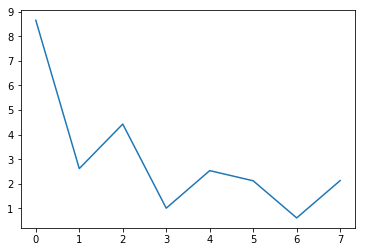

In [14]:
print('grad: ', grad_np)
plt.plot(grad_np)

In [15]:
# Taylor test
h = dfa.Function(rom.coarseSolver.diffusivityFunctionSpace)
h.vector()[:] = 0.1
dfa.taylor_test(RF, diffusivityFunction, h)

p_n =  [ -9382.4991873   -9401.16176038  -9375.22372314 ...,  23296.82476177
  23315.42112511  23118.60282695]
u_c =  [ 0.77298748  0.44404851  0.00375299  0.10737885  0.09185444 -0.95536732
  0.04395746 -0.48790947 -0.18436356]
Difference vec:  [  2.32549308e+04   1.57828076e+04  -7.48009532e+03  -9.27614242e-01
  -5.72481334e+03  -4.63683988e+04  -3.97667298e+03  -3.77845270e+04
  -9.38231482e+03]
adj_output =  f_319
adj_output.vector() =  <PETScVector of size 9>
adj_output_np =  [  2.32549308e+04   1.57828076e+04  -7.48009532e+03  -9.27614242e-01
  -5.72481334e+03  -4.63683988e+04  -3.97667298e+03  -3.77845270e+04
  -9.38231482e+03]
Running Taylor test
p_n =  [ -9382.4991873   -9401.16176038  -9375.22372314 ...,  23296.82476177
  23315.42112511  23118.60282695]
u_c =  [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
Difference vec:  [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
p_n =  [ -9382.4991873   -9401.16176038  -9375.22372314 ...,  23296.82476177
  23315.42112511  23118.602826

nan